## Mask RCNN - Inspect Lane training data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import skimage
import skimage.draw

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/My Drive/Mask_RCNN-master")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.lane import lane

%matplotlib inline

Using TensorFlow backend.


### DATASET

In [0]:
config = lane.LaneConfig()
LANE_DIR = os.path.join(ROOT_DIR, "datasets/lane")

In [0]:
dataset = lane.LaneDataset()
dataset.load_lane(LANE_DIR, "train")

In [0]:
dataset.prepare()

In [6]:
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 15
Class Count: 2
  0. BG                                                
  1. lane                                              


### DISPLAYING SAMPLES

In [7]:
image_ids = np.random.choice(dataset.image_ids, 4)
image_ids

array([ 4, 10, 13, 12])

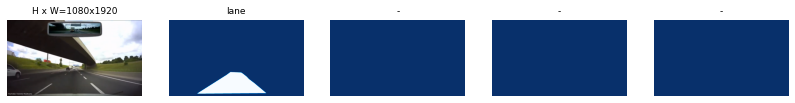

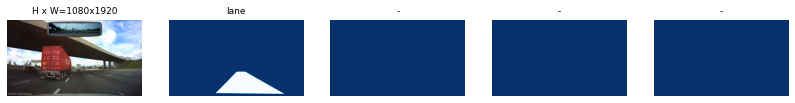

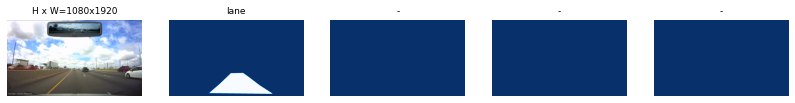

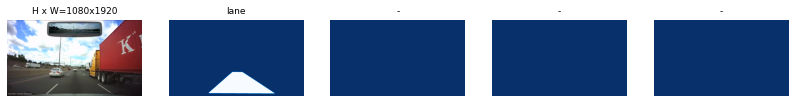

In [8]:
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

### BOUNDING BOXES

In [0]:
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)

In [0]:
mask, class_ids = dataset.load_mask(image_id)

In [0]:
bbox = utils.extract_bboxes(mask)

In [13]:
# Display additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

image_id  13 None
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1080, 1920, 1)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  569.00000  max: 1475.00000  int32


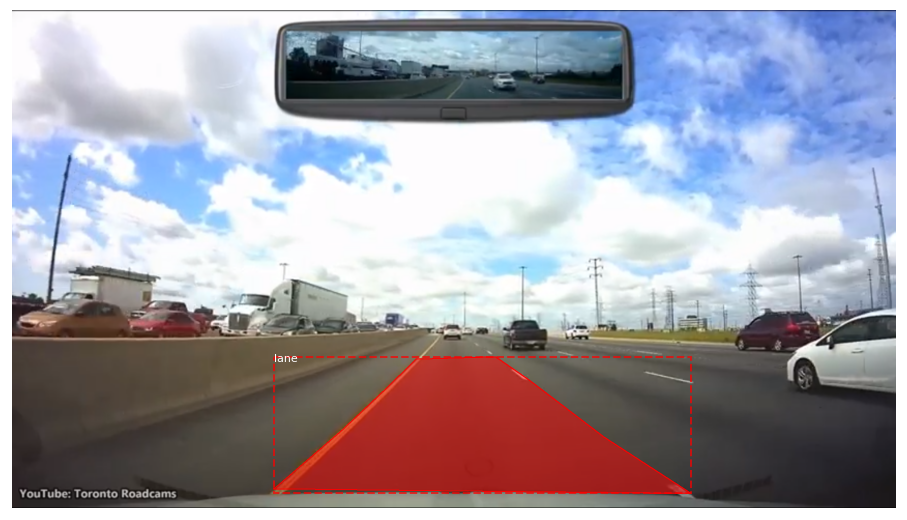

In [14]:
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

### RESIZE IMAGES

In [0]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape

In [0]:
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)

In [19]:
print(window,scale,padding)

(224, 0, 800, 1024) 0.5333333333333333 [(224, 224), (0, 0), (0, 0)]


In [0]:
mask = utils.resize_mask(mask, scale, padding)

In [0]:
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

In [23]:
# Display additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

image_id:  10 None
Original shape:  (1080, 1920, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  352.00000  max:  874.00000  int32


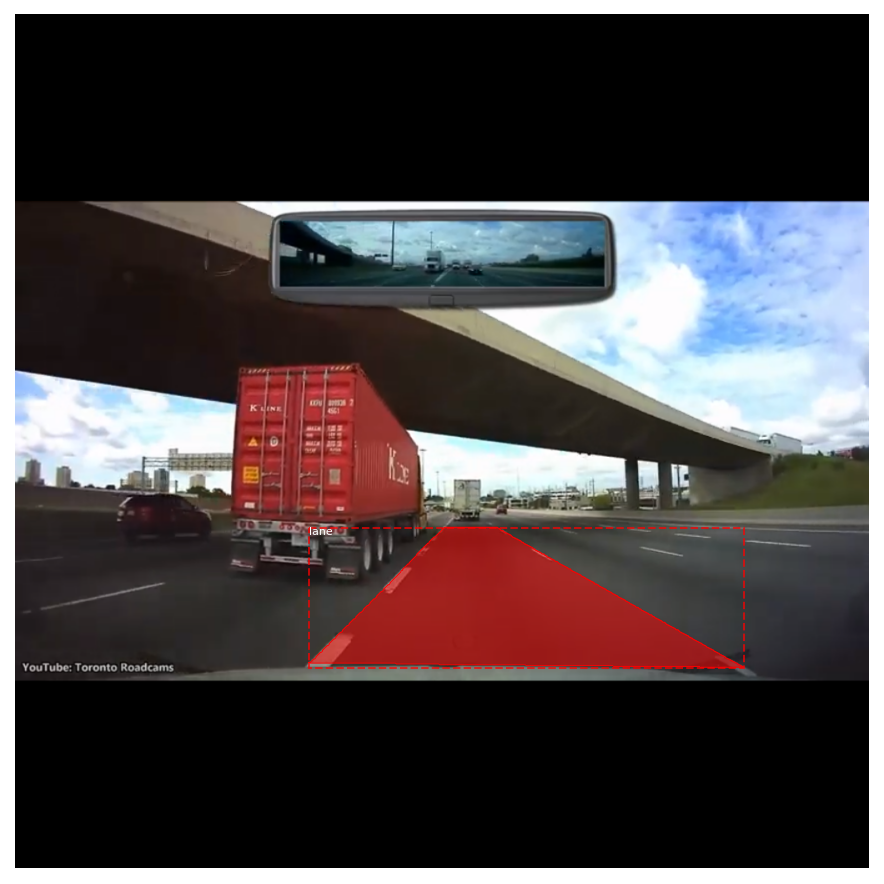

In [24]:
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)


### Mini Masks
Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone.

To improve training speed, we optimize masks by:

- We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
- We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

In [0]:
image_id = np.random.choice(dataset.image_ids, 1)[0]

In [0]:
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)